## Dropout regularization
* ### LR Scheduler Callback

In [ ]:
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

In [ ]:
tf.config.list_physical_devices('GPU')

## Fashion MNIST classification dataset

In [3]:
fashion_mnist=tf.keras.datasets.fashion_mnist.load_data()

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

In [5]:
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [6]:
X_train.shape

(55000, 28, 28)

In [7]:
X_train.dtype

dtype('uint8')

## Data normalization

In [8]:
X_train, X_valid, X_test = X_train/255., X_valid/255., X_test/255. 

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [10]:
tf.random.set_seed(42)

## Model definition

In [ ]:
model = K.Sequential()

In [12]:
model

In [13]:
RegularizedDense = partial(K.layers.Dense,
                          activation='relu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=K.regularizers.l2(0.01))

In [14]:
model.add(K.layers.Input(shape=[28, 28]))
model.add(K.layers.Flatten())
model.add(K.layers.Dropout(rate=0.2))
model.add(RegularizedDense(300))
model.add(K.layers.Dropout(rate=0.2))
model.add(RegularizedDense(100))
model.add(K.layers.Dropout(rate=0.2))
model.add(K.layers.Dense(10, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1

In [16]:
model.compile(loss=K.losses.sparse_categorical_crossentropy,
             optimizer=K.optimizers.SGD(),
             metrics=[K.metrics.sparse_categorical_accuracy])

## Learning rate scheduler using exponential decay over epochs

In [17]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        assert s>0, 's shoud be positive'
        return lr0 * 0.01 ** (epoch/s)
    return exponential_decay_fn

In [18]:
exponential_decay_fn = exponential_decay(lr0=0.1, s=20)

## LR Scheduler Callback

In [19]:
lr_scheduler = K.callbacks.LearningRateScheduler(exponential_decay_fn)

## Training

In [20]:
history = model.fit(X_train, y_train, 
         epochs=30,
         validation_data=[X_valid, y_valid],
         callbacks=[lr_scheduler])

Epoch 1/30
  59/1719 [>.............................] - ETA: 2s - loss: 8.5855 - sparse_categorical_accuracy: 0.4979  

2023-07-07 15:27:11.817940: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1719/1719 [==============================] - 3s 1ms/step - loss: 2.0454 - sparse_categorical_accuracy: 0.7428 - val_loss: 0.7701 - val_sparse_categorical_accuracy: 0.7954 - lr: 0.1000
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7857 - sparse_categorical_accuracy: 0.7811 - val_loss: 0.6918 - val_sparse_categorical_accuracy: 0.8126 - lr: 0.0794
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7366 - sparse_categorical_accuracy: 0.7944 - val_loss: 0.7099 - val_sparse_categorical_accuracy: 0.8100 - lr: 0.0631
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7093 - sparse_categorical_accuracy: 0.8007 - val_loss: 0.6403 - val_sparse_categorical_accuracy: 0.8300 - lr: 0.0501
Epoch 5/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6864 - sparse_categorical_accuracy: 0.8065 - val_loss: 0.6103 - val_sparse_categorical_accuracy: 0.8358 - lr: 0.0398
Epoch 6/30
1719/1719 [==============

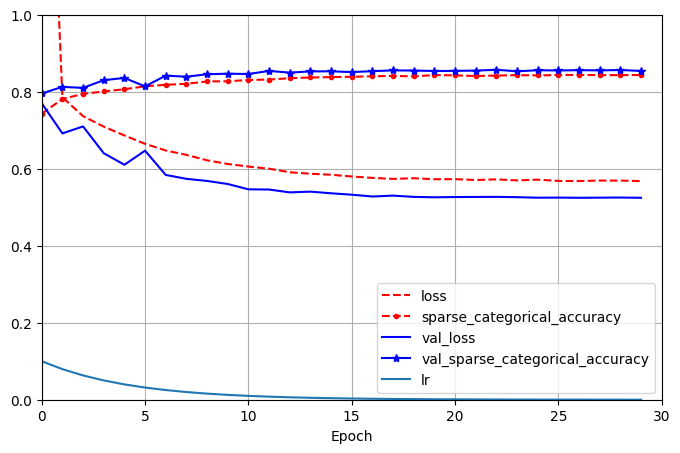

In [21]:
pd.DataFrame(history.history).plot(figsize=(8, 5),
                                  xlim=[0, history.params['epochs']],
                                  ylim=[0, 1],
                                  grid=True,
                                  xlabel='Epoch',
                                  style=["r--", "r--.", "b-", "b-*"])
plt.show()

In [22]:
y_probas = np.stack([model(X_test, training=True) for sample in range(100)])

In [23]:
y_proba = y_probas.mean(axis=0)

In [24]:
model.predict(X_test[:1]).round(3)

1/1 [==============================] - 0s 60ms/step


array([[0.   , 0.001, 0.   , 0.001, 0.   , 0.148, 0.   , 0.314, 0.007,
        0.528]], dtype=float32)

In [25]:
y_proba[0].round(3)

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.176, 0.001, 0.288, 0.01 ,
       0.521], dtype=float32)

In [26]:
y_test[0]

9

In [27]:
y_pred = y_proba.argmax(axis=1)

In [28]:
(y_pred == y_test).sum()/len(y_test)

0.8486

In [29]:
y_pred_m = model.predict(X_test).argmax(axis=1)

313/313 [==============================] - 0s 707us/step


In [30]:
(y_pred_m == y_test).sum()/len(y_test)

0.8477

In [31]:
y_val_m = model.predict(X_valid).argmax(axis=1)

157/157 [==============================] - 0s 679us/step


In [32]:
(y_val_m == y_valid).sum()/len(y_valid)

0.854